# Group Project EDA Playground (MPG and Concrete Data)

In [1]:
# If some libraries are missing, start the R interactive command line and run install.packages(<missing-package-name-here>)

library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.11     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata    0.1.1      ✔ workflowsets 0.1.0 
✔ parsnip      0.2.0      ✔ yardstick    0.0.9 
✔ recipes      0.2.0 

In [2]:
power <- read_excel("data/powerplant-fulload-data.xlsx")
colnames(power) <- c("AvgAmbientTemperatureC", "ExhaustVacuum_cm_Hg", "AvgAmbientPressureMilibars", "RelativeHumidity", "NetEnergyOutputMegaWatts")
power %>% head(8)

AvgAmbientTemperatureC,ExhaustVacuum_cm_Hg,AvgAmbientPressureMilibars,RelativeHumidity,NetEnergyOutputMegaWatts
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14.96,41.76,1024.07,73.17,463.26
25.18,62.96,1020.04,59.08,444.37
5.11,39.40,1012.16,92.14,488.56
20.86,57.32,1010.24,76.64,446.48
10.82,37.50,1009.23,96.62,473.90
26.27,59.44,1012.23,58.77,443.67
15.89,43.96,1014.02,75.24,467.35
9.48,44.71,1019.12,66.43,478.42


In [3]:
min_df <- power %>% 
            map_df(min)
max_df <- power %>%
            map_df(max)
mean_df <- power %>%
            map_df(mean)
sd_df <- power %>%
            map_df(sd)
var_df <- power %>%
            map_df(var)
count_nan_df <- power %>% 
                map_df(~sum(is.na(.)))

# get a vector of all the columns to join by
join_cols = colnames(power)

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>%
                            full_join(., count_nan_df, by=join_cols) %>%
                mutate(stat_type = c("min", "max", "mean", "var", "st_dev", "nan_count")) %>% 
                mutate(stat_type = as_factor(stat_type)) %>% 
                relocate(stat_type) 

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type,AvgAmbientTemperatureC,ExhaustVacuum_cm_Hg,AvgAmbientPressureMilibars,RelativeHumidity,NetEnergyOutputMegaWatts
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
min,1.810000,25.36000,992.890000,25.56000,420.26000
max,37.110000,81.56000,1033.300000,100.16000,495.76000
mean,19.651231,54.30580,1013.259078,73.30898,454.36501
var,55.539357,161.49054,35.269152,213.16785,291.28232
st_dev,7.452473,12.70789,5.938784,14.60027,17.06699
nan_count,0.000000,0.00000,0.000000,0.00000,0.00000


The below pair plot provides an quick visual data overview. I think we are in good shape for a simple MLR model on this dataset. 

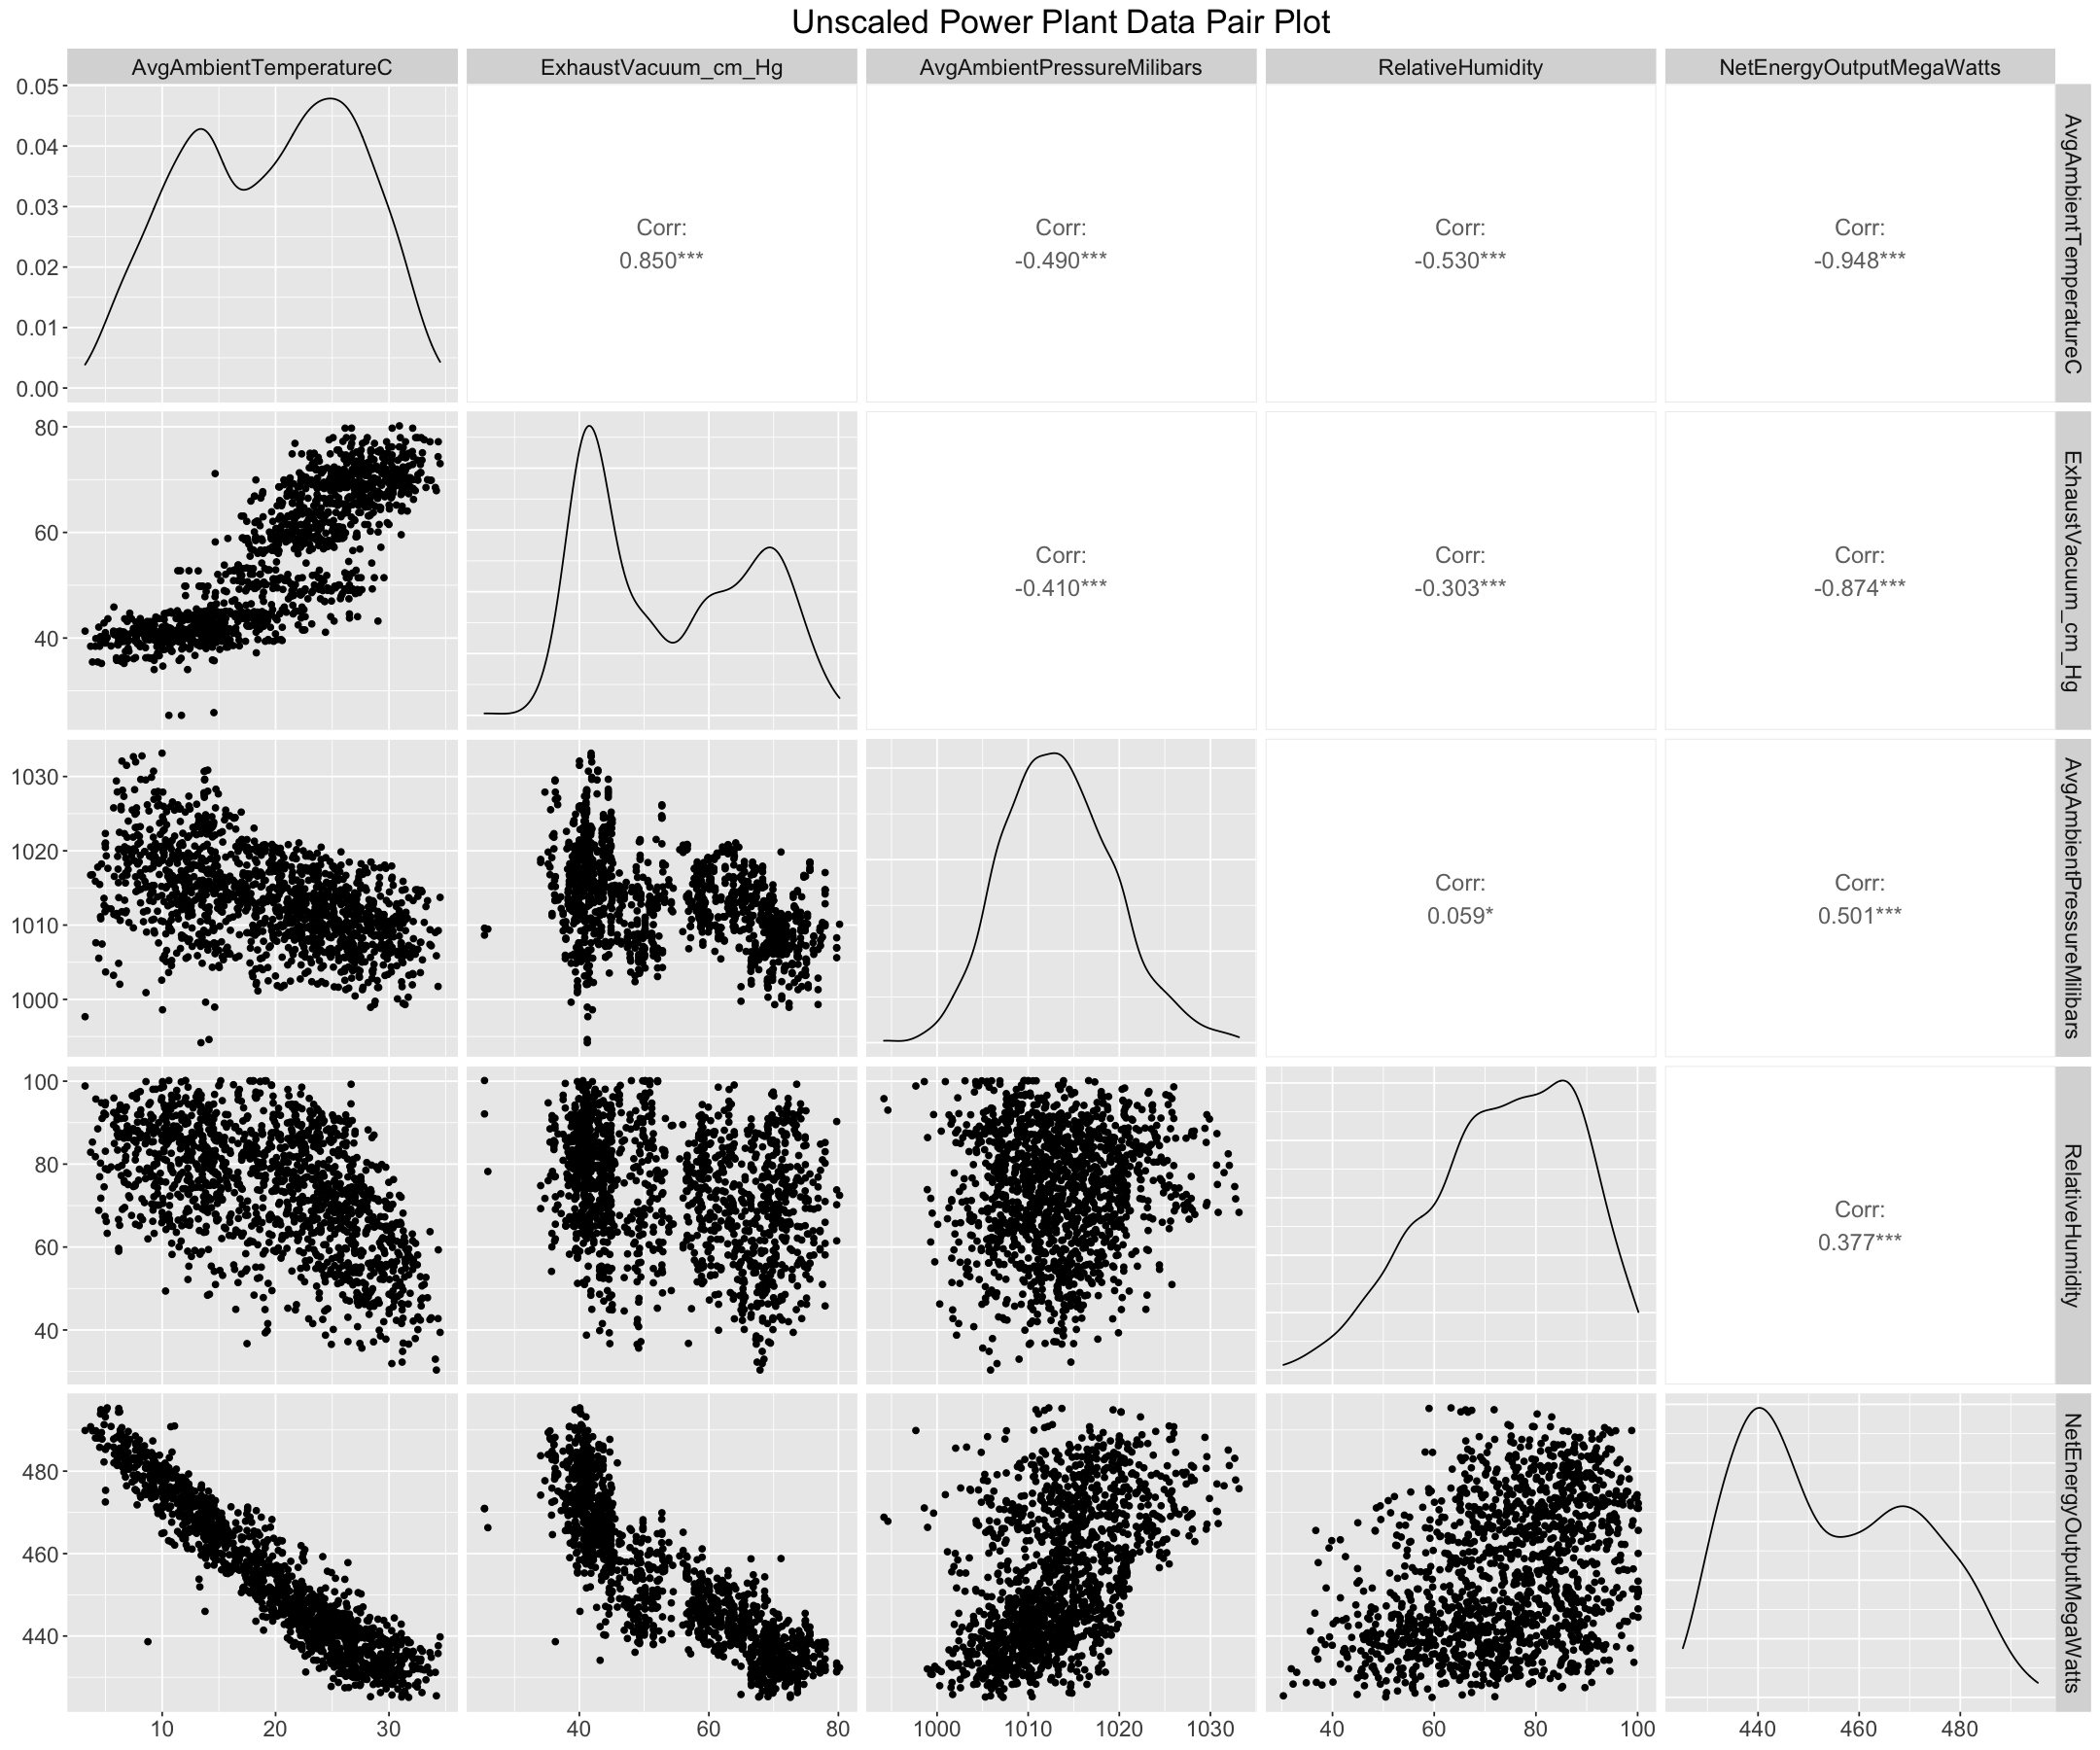

In [4]:
# set plot size options
options(repr.plot.width = 18, repr.plot.height = 15)

# subset the data for plotting (just looks like black blobs otherwise)
power_subset <- power %>% sample_frac(0.15) 

# pair plot for concrete data
ggpairs(power_subset,
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Unscaled Power Plant Data Pair Plot") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))